In [64]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
from gpflow.kernels import SquaredExponential as SE
from gpflow.kernels import RationalQuadratic as RQ
from gpflow.kernels import Linear, Periodic

In [76]:
def generate_synthetic_data(kernels, likelihoods, xmin=0., xmax=2.):
    x = np.linspace(xmin, xmax, 1000).reshape(-1,1)
    x_train_index = list(range(1000)[::5])
    y_train, y_true = [],[]
    inputx = x
    plt.figure(figsize=(20, len(kernels)*3))
    for i in range(len(kernels)):
        Kx = kernels[i](inputx)
        h = np.random.multivariate_normal(np.zeros(1000), Kx)[:,None]
        h_train = h[x_train_index]
        if likelihoods[i][0]=='Gaussian':
            y = h_train + np.random.normal(0, likelihoods[i][1], 200).reshape(-1,1)
        elif likelihoods[i][0]=='Binary':
            h_train = h_train-np.mean(h_train)
            h = h-np.mean(h)
            y = 1./(1.+np.exp(-h_train))
            h = 1./(1.+np.exp(-h))
            print(h.shape)
            y = np.random.RandomState(0).binomial(1,y)#np.where(y>0.5, 1,0)
            print(y.shape)
        else:
            print('not implemented')
        
        plt.subplot(len(kernels),1, i+1)
        plt.scatter(x[x_train_index], y, c='black', label='Train', s=10)
        plt.plot(x, h)
        plt.ylabel('output '+str(i))
        
        y_train.append(y)
        y_true.append(h)
        
        inputx = np.concatenate((inputx, h), axis=1)
    return x[x_train_index], y_train, x, y_true

(1000, 1)
(200, 1)
(1000, 1)
(200, 1)


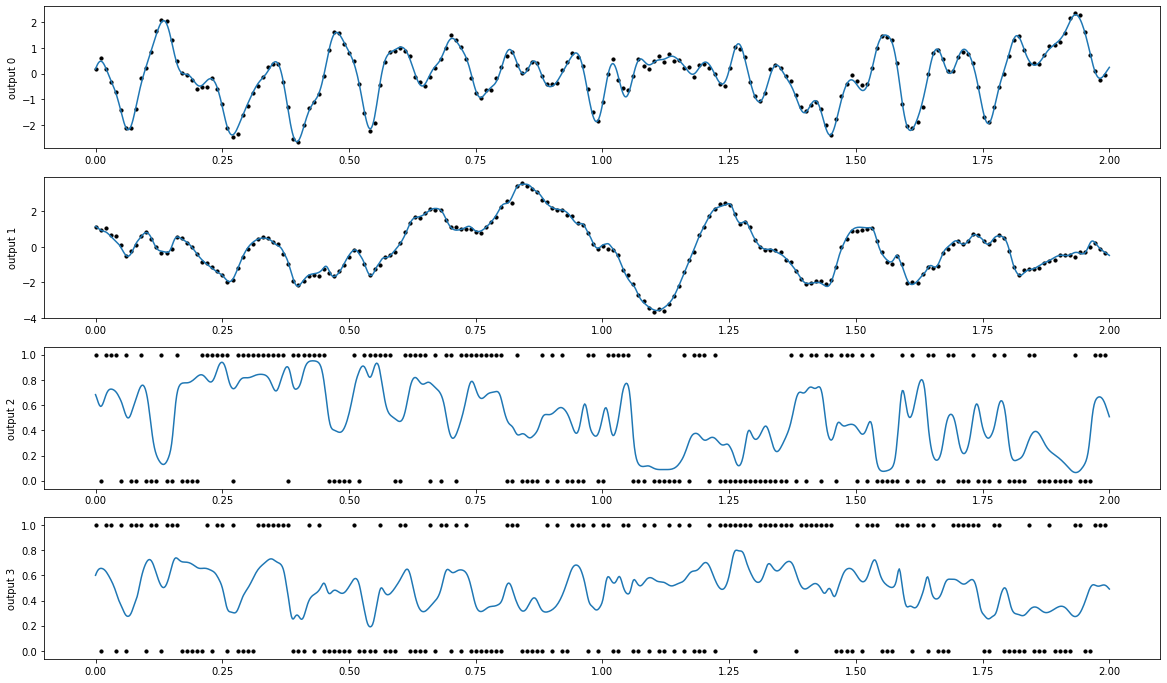

In [166]:
kernels = [SE(active_dims=[0],variance=1.,lengthscales=0.02),
           SE(active_dims=[0],variance=2.,lengthscales=0.05)
               +SE(active_dims=[1],variance=1.,lengthscales=[1]),
           SE(active_dims=[0],variance=1,lengthscales=0.5)
               +SE(active_dims=[1,2],variance=1, lengthscales=[1,2]),
           SE(active_dims=[0],variance=1,lengthscales=0.3)
               +SE(active_dims=[1,2,3],variance=1,lengthscales=[1,2,1])]
likelihoods = [['Gaussian', 0.1],
               ['Gaussian', 0.1],
               ['Binary', ],
               ['Binary', ]]

x_train, y_train, x_test, y_test = generate_synthetic_data(kernels, likelihoods)

In [79]:
import sys
from gpflow.ci_utils import ci_niter
sys.path.append('../code')
from gplar_q import GPLARmodel
from gpar.regression import GPARRegressor

In [167]:
y_train = np.array(y_train)

In [168]:
y_train[3,100:150]=None

In [169]:
def meanstd(y, likelihoods):
    mean, std = [],[]
    new_y = []
    for i, likelihood in enumerate(likelihoods):
        if likelihood[0] == 'Gaussian':
            available = ~np.isnan(y[i][:,0])
            y_i = y[i][available,0]
            new_y_i = (y[i][:,0] - np.mean(y_i))/np.std(y_i)
            new_y.append(new_y_i)
            mean.append(np.mean(y_i))
            std.append(np.std(y_i))
        else:
            new_y.append(y[i][:,0])
            mean.append(None)
            std.append(None)
    return np.stack(new_y,axis=1), np.stack(mean), np.stack(std)

y_train_norm, mean, std= meanstd(y_train, likelihoods)

In [170]:
M = 200

gpar = GPARRegressor(scale=0.02,
                linear=False, linear_scale=10.,
                nonlinear=True, nonlinear_scale=1.,
                noise=0.01,
                impute=True, replace=True, normalise_y=True)

gplar = GPLARmodel(x_train, y_train_norm, M, gpar, white=False,
                   scale=0.02, linear=False, linear_scale=10.0,
                   nonlinear=True, nonlinear_scale=1.0,
                   noise_inner=1e-5, noise_obs=0.01,
                   num_samples=1)

Training conditionals (total: 4): 1 2 3 4
Sampling (total: 50): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50


In [171]:
gplar_likelihoods = []
for likelihood in likelihoods:
    if likelihood[0] == 'Gaussian':
        gplar_likelihoods.append(gpflow.likelihoods.Gaussian(variance=likelihood[1]))
    elif likelihood[0] == 'Binary':
        gplar_likelihoods.append(gpflow.likelihoods.Bernoulli())

In [172]:
gplar.likelihoods = gplar_likelihoods

In [ ]:
@tf.function(autograph=False)
def optimization_step(optimizer, model, data):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = -model.maximum_log_likelihood_objective(*data)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, data, iterations):
    logf = []
    adam = tf.optimizers.Adam(0.001)
    for step in range(iterations):
        neg_elbo= optimization_step(adam, model, data)
        elbo = -neg_elbo
        if step%100 == 0:
            logf.append(elbo.numpy())
        if step%1000 == 0:
            print(elbo.numpy())
    return logf

maxiter = ci_niter(100000)
logf = run_adam(gplar, (x_train, y_train_norm), maxiter)

In [9]:
gpflow.utilities.print_summary(gplar, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
GPLARmodel.inducing_inputs.Z GPLARmodel.layers[0].inducing_points,Parameter,,,True,"(200, 1)",float64,[[-0.04193229...
GPLARmodel.likelihoods[0].variance,Parameter,Softplus + Shift,,True,(),float64,0.012943888245222692
GPLARmodel.likelihoods[1].variance,Parameter,Softplus + Shift,,True,(),float64,0.004610562181679937
GPLARmodel.likelihoods[2].variance,Parameter,Softplus + Shift,,True,(),float64,0.001087994135360753
GPLARmodel.likelihoods[3].variance,Parameter,Softplus + Shift,,True,(),float64,0.004949692724781181
GPLARmodel.layers[0].q_mu,Parameter,,,True,"(200, 1)",float64,[[4.67838378e-02...
GPLARmodel.layers[0].q_sqrt,Parameter,FillTriangular,,True,"(200, 200)",float64,"[[1.03642517e+00, 0.00000000e+00, 0.00000000e+00..."
GPLARmodel.layers[0].kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.00012332878296943822
GPLARmodel.layers[0].kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.1587551649905767
GPLARmodel.layers[0].kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.020278604611237056


In [174]:
def predict_y(self, Xnew, num_samples, full_cov=False):
        Hmean, Hvar = self._predict(Xnew, full_cov=full_cov, S=num_samples)
        ms, vs = [],[]
        for i in range(len(self.likelihoods)):
            mean, var = self.likelihoods[i].predict_mean_and_var(Hmean[i],Hvar[i])
            ms.append(mean)
            vs.append(var)
        return np.squeeze(np.stack(ms,axis=2)), np.squeeze(np.stack(vs,axis=2))

In [175]:
ms, vs = predict_y(gplar, x_test, num_samples=100)

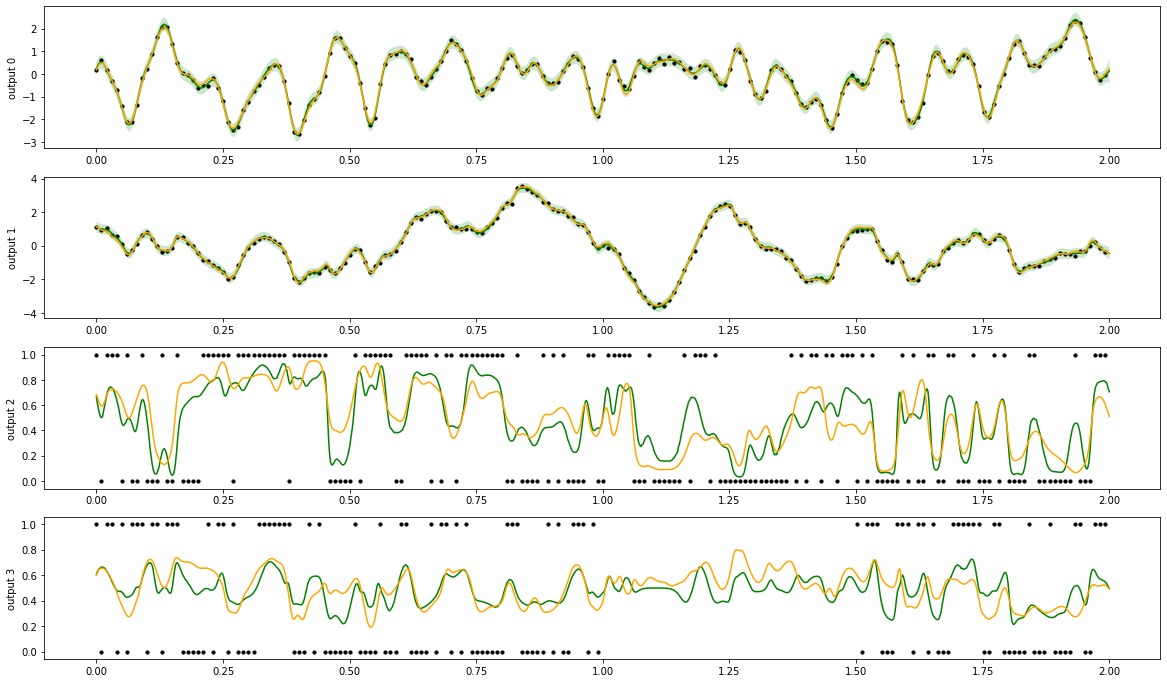

In [176]:
plt.figure(figsize=(20, len(likelihoods)*3))
for i in range(len(likelihoods)):
    plt.subplot(len(kernels),1, i+1)

    if likelihoods[i][0]=='Gaussian':
        predicted_mean = np.mean(ms[:,:,i],axis=0)
        predicted_var = np.mean(ms[:,:,i]**2 + vs[:,:,i] + gplar.likelihoods[i].variance.value().numpy(), axis=0)-predicted_mean**2
        predicted_mean = predicted_mean*std[i]+mean[i]
        predicted_std = np.sqrt(predicted_var)*std[i]
        
        plt.plot(x_test[:,0], predicted_mean, c='green', label = 'GPLAR')
        plt.fill_between(x_test[:,0], predicted_mean-1.96*predicted_std, 
                         predicted_mean+1.96*predicted_std, facecolor='tab:green', alpha=.25)

    elif likelihoods[i][0]=='Binary':
        predicted_mean = np.mean(ms[:,:,i],axis=0)
        plt.plot(x_test[:,0], predicted_mean, c='green', label = 'GPLAR')
    else:
        print('not implemented')
        
    if i==3:
        plt.scatter(x_train[125:150,0],y_train[i][125:150], c='purple', label='missing', s=15)

    plt.scatter(x_train[:,0], y_train[i], c='black', label='Train', s=10)
    plt.plot(x_test[:,0], y_test[i], c='orange', label='True')
    plt.ylabel('output '+str(i))
plt.savefig('hetero-try2.png',dpi=300)

In [177]:
x_m_train = np.concatenate((x_train[:100,0], x_train[150:,0]))

In [178]:
y_m_train = np.concatenate((y_train[3][:100], y_train[3][150:]))

In [179]:
m = gpflow.models.VGP(
    (x_m_train[:,None], y_m_train), likelihood=gpflow.likelihoods.Bernoulli(), kernel=gpflow.kernels.SquaredExponential(lengthscales=0.03)
)

opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)

      fun: 103.08024244856554
 hess_inv: <11477x11477 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.85675544e-04, -1.10520748e-04,  7.84211387e-06, ...,
       -8.83321364e-06,  6.40004715e-06, -1.07002945e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 64
      nit: 56
   status: 0
  success: True
        x: array([-4.29634116, -1.15663576,  0.19469321, ..., -0.03130278,
       -0.08902438,  0.93935287])

In [180]:
mu, var = m.predict_f(x_test)

In [181]:
mu, var = m.likelihood.predict_mean_and_var(mu, var)

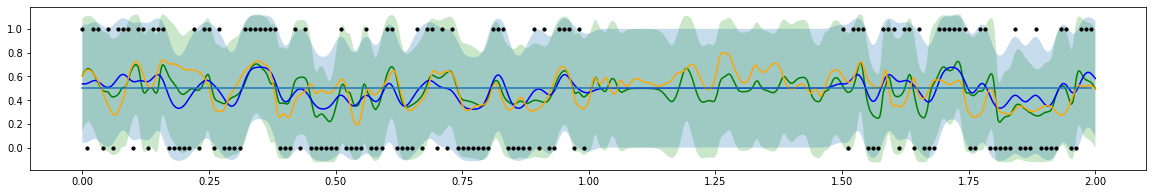

In [182]:
plt.figure(figsize=(20, 3))
predicted_mean = np.mean(ms[:,:,3],axis=0)
predicted_var = np.mean(vs[:,:,3],axis=0)
plt.plot(x_test[:,0], predicted_mean, c='green', label = 'GPLAR')
plt.fill_between(x_test[:,0], predicted_mean-2*predicted_var, predicted_mean+2*predicted_var, facecolor='tab:green', alpha=.25)
plt.plot(x_test[:,0], mu, c='blue', label = 'Independent')
plt.fill_between(x_test[:,0], mu[:,0]-2*var[:,0], mu[:,0]+2*var[:,0], facecolor='tab:blue', alpha=.25)
plt.scatter(x_train[100:150,0],y_train[3][100:150], c='red', label='missing', s=15)

plt.scatter(x_train[:,0], y_train[3], c='black', label='Train', s=10)
plt.plot(x_test[:,0], y_test[3], c='orange', label='True')
plt.plot(x_train[:,0],[0.5]*200)
plt.savefig('hetero-linear.png',dpi=300)